In [1]:
import sys
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
import numpy as np
import pdb
import copy
import copy
import torch
# !pip3 install swig
# !pip3 install box2d-py
# !pip3 install gym[Box_2D]
# !pip install gym[box2d]
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    T.manual_seed(seed)
    T.cuda.manual_seed(seed)
    T.backends.cudnn.deterministic = True

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), keepdims=True)

device = T.device("cuda" if T.cuda.is_available() else "cpu")

In [2]:
class replayBuffer:
    def __init__(self,maxSize,stateDim):
        self.state=np.zeros((maxSize,stateDim))
        self.action=np.zeros(maxSize,dtype= np.int8)
        self.reward=np.zeros(maxSize)
        self.done=np.zeros(maxSize,dtype= np.int8)
        self.nextState=np.zeros((maxSize,stateDim))
        self.maxSize=maxSize
        self.curser=0
        self.size=0

    def save(self,state,action,reward,nextState,done):
        self.state[self.curser]=state
        self.action[self.curser]=action
        self.reward[self.curser]=reward
        self.nextState[self.curser]=nextState
        self.done[self.curser]=done
        self.curser=(self.curser+1)%self.maxSize
        if self.size<self.maxSize:
            self.size+=1

    def sample(self,batchSize):
        batchSize=min(self.size,batchSize)
        indexes=np.random.choice([i for i in range(self.size-1)],batchSize)
        return self.state[indexes],self.action[indexes],self.reward[indexes],self.nextState[indexes],self.done[indexes]

In [3]:
class Q_network(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Q_network, self).__init__()
        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
    def forward(self, state):
        q = F.relu(self.l1(state))
        q = F.relu(self.l2(q))
        return self.l3(q)

In [4]:
from copy import deepcopy
class Agent:
    def __init__(self,stateShape,actionShape,exploreRate,exploreRateDecay,minimumExploreRate,gamma,copyNetsCycle):
        self.gamma=gamma
        self.exploreRate=exploreRate
        self.exploreRateDecay=exploreRateDecay
        self.minimumExploreRate=minimumExploreRate
        self.actionShape=actionShape
        self.replay_buffer=replayBuffer(1000000,stateShape)

        self.model=Q_network(stateShape,actionShape)
        self.model_optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        self.tModel=Q_network(stateShape,actionShape)
        self.learnThreshold=0
        self.copyNetsCycle=copyNetsCycle

    def getAction(self,state,evaluation_mode=False):
        with T.no_grad():
            state=T.tensor([state],dtype=T.float).to(self.model.device)
            q=self.model(state).numpy()
        if np.random.random()<=self.exploreRate and (not(evaluation_mode)):
            return np.random.choice([i for i in range(self.actionShape)])
        else:
            return np.argmax(q)

    def exploreDecay(self):
        self.exploreRate=max(self.exploreRate*self.exploreRateDecay,self.minimumExploreRate)

    def learn(self,batch_size=64):
        
        if self.replay_buffer.size>batch_size:
            states, actions, rewards, states_, dones = self.replay_buffer.sample(batch_size)
            states=T.tensor(states,dtype=T.float).to(self.model.device)
            actions,T.tensor([actions],dtype=T.int).to(self.model.device)
            rewards=T.tensor([rewards],dtype=T.float).to(self.model.device)
            states_=T.tensor(states_,dtype=T.float).to(self.model.device)
            dones=T.tensor([dones],dtype=T.int).to(self.model.device)
            
            
            indices = np.arange(batch_size)
            self.model_optimizer.zero_grad()
            q_pred = self.model.forward(states)[indices, actions]
            q_next = self.tModel.forward(states_)
            q_eval = self.model.forward(states_)

            max_actions = T.argmax(q_eval, dim=1)
            q_target = rewards + self.gamma * (dones * q_next[indices, max_actions])
            loss = F.mse_loss(q_pred,q_target)
            loss.backward()

            self.model_optimizer.step()
            self.learnThreshold+=1  
            self.exploreDecay()
            
            if(self.learnThreshold%self.copyNetsCycle)==0:
                  self.tModel=deepcopy(self.model)

In [5]:
class Environment:
    def __init__(self,lines_passenger_generator,num_buses=20):
        self.bus_capacity=20
        self.lines_passenger_generator=lines_passenger_generator
        self.num_buses=num_buses
        self.action_n=len(self.lines_passenger_generator.keys())+1
        self.line_gen_mean=np.concatenate([self.lines_passenger_generator[key] for key in self.lines_passenger_generator.keys()])
 
    def reset(self):
        self.steps_so_far=0
        self.buses_places=np.array([-1 for i in range(self.num_buses)])
        self.current_passengers=self.generate_passengers(self.line_gen_mean)
        self.line_seperators=[]
        start=0
        for key in self.lines_passenger_generator.keys():
            end=len(self.lines_passenger_generator[key])
            self.line_seperators.append((start,start+end))
            start=end
        return self.get_state()
    
    def get_state(self):
        return np.concatenate([self.current_passengers,self.buses_places])
    
    def move_buses(self):
        reward=-sum(self.current_passengers)
        for index in range(len(self.buses_places)):
            for start,end in self.line_seperators:
                if self.buses_places[index] >=start and self.buses_places[index]<end:
                    reward+= 3 * min(self.current_passengers[self.buses_places[index]],self.bus_capacity)
                    self.current_passengers[self.buses_places[index]]=max(self.current_passengers[self.buses_places[index]]-self.bus_capacity,0)
                    self.buses_places[index]+=1
                    if self.buses_places[index]==end:
                        self.buses_places[index]=-1
        return reward
    
    def step(self, action):
        if action<len(self.line_seperators):
            index=np.where(self.buses_places == -1)[0]
            if index.size != 0:
                self.buses_places[index[0]]=self.line_seperators[action][0]
        reward=self.move_buses()
        self.current_passengers+=self.generate_passengers(self.line_gen_mean)
        self.steps_so_far+=1
        return self.get_state(),reward,0,1 if self.steps_so_far>1000 else 0
    
    def generate_passengers(self,mean):
        sample=np.abs(np.random.randn()) + np.array(mean)
        return sample.astype(int)
    
lines_passenger_generator={'line_1':[1,2,3,3,1,3,4,4,3,4,2,1],'line_2':[6,7,4,3,8,9,7,6,8,9,8,3,4,4,9,9]}
env=Environment(lines_passenger_generator,15)
print(env.reset())
# print(env.step(2))
# print(env.step(1))

[ 1  2  3  3  1  3  4  4  3  4  2  1  6  7  4  3  8  9  7  6  8  9  8  3
  4  4  9  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [6]:
env.get_state().shape[0],env.action_n

(43, 3)

In [7]:
agent=Agent(stateShape=env.get_state().shape[0],actionShape=env.action_n\
            ,exploreRate=1.0,exploreRateDecay=0.9999,minimumExploreRate=0.01,gamma=0.99,copyNetsCycle=100)

In [8]:
# agent.loadModel("DoubleDQN_LunarLanderV2.h")
averageRewards=[]
totalRewards=[]
for i in range(1,200):
  done = False
  truncuated = False
  state=env.reset()
  rewards=0
  while (not done) and (not truncuated):
    action=agent.getAction(state)#np.random.choice([i for i in range(3)])
    nextState,reward,done,truncuated=env.step(action)
    agent.replay_buffer.save(state,action,reward,nextState,int(1-done))
    rewards+=reward
    state=nextState
    agent.learn(batch_size=64)
  print(state)
  totalRewards.append(rewards)
  averageRewards.append(sum(totalRewards)/len(totalRewards))
  print(f"episode: {i}   reward: {rewards}  avg so far:{averageRewards[-1]} exploreRate:{agent.exploreRate}")

/tmp/ipykernel_18/4287692848.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  state=T.tensor([state],dtype=T.float).to(self.model.device)
/tmp/ipykernel_18/4287692848.py:48: UserWarning: Using a target size (torch.Size([1, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_pred,q_target)


[   1    2    3   10    3    3   13    9    3   13    5    1  201  660
    9    3 1651 2673  669  195 1691 2693 1711   22   35   30 2733 2753
   27    9   22   16   -1    1   23   20    6   17    3    2   -1   -1
   -1]
episode: 1   reward: -8539546  avg so far:-8539546.0 exploreRate:0.91055162180751
[   3    3   29   46   19   39   52   47   29   39   16    9   57  107
    9    4  822 1844  110   93  862 1884  882   30   72   68 1944 1964
   21   19   17   16   27   26   24   23    3    2   13   -1   -1   -1
   -1]
episode: 2   reward: -6129995  avg so far:-7334770.5 exploreRate:0.8238146689886557
[  7   6   4  19   8  13 230 225   9 236  16   9  14  31  10   4  75 114
  73  61 103 118  87   4  31  47 133 123  16  18  25  24  17  10  23   8
  19   3  14  -1  -1  -1  -1]
episode: 3   reward: -1641569  avg so far:-5437036.666666667 exploreRate:0.7453400692359197
[ 4  5 18 35  5 48 93 88 56 99 11  4 17 17 17 10 21 17 22 13  9 10  9  4
  5 13 26 17  4 24 23  8 -1 22 21 18  3 14 -1 -1 25 -

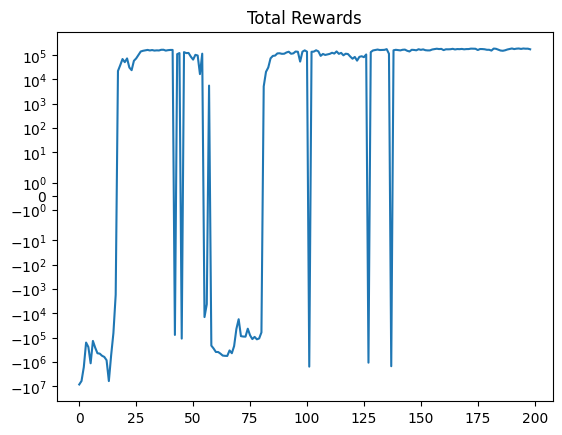

In [9]:
import matplotlib.pyplot as plt
plt.title(f'Total Rewards')
plt.yscale('symlog')
plt.plot(totalRewards)
plt.savefig("Total Rewards",dpi=200)

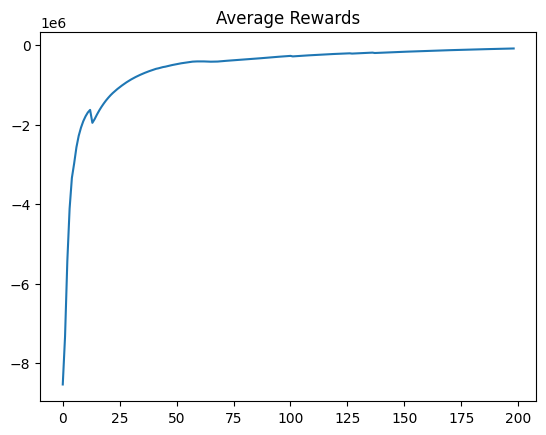

In [10]:
plt.clf()
plt.title(f'Average Rewards')
#plt.yscale('symlog')
plt.plot(averageRewards)
plt.savefig("Average Rewards",dpi=200)

In [11]:
# agent.loadModel("DoubleDQN_LunarLanderV2.h")
averageRewards=[]
totalRewards=[]
for i in range(1,200):
  done = False
  truncuated = False
  state=env.reset()
  rewards=0
  while (not done) and (not truncuated):
    action=np.random.choice([i for i in range(3)])#agent.getAction(state)
    nextState,reward,done,truncuated=env.step(action)
#     agent.replay_buffer.save(state,action,reward,nextState,int(1-done))
    rewards+=reward
    state=nextState
#     agent.learn(batch_size=64)
  print(state)
  totalRewards.append(rewards)
  averageRewards.append(sum(totalRewards)/len(totalRewards))
  print(f"episode: {i}   reward: {rewards}  avg so far:{averageRewards[-1]} exploreRate:{agent.exploreRate}")

[   4    3   19   15    6    8    5   15    8    5    6    2  264  786
   44   21 1750 2772  790  259 1790 2792 1790   36   40   36 2792 2792
   17    2   -1   -1   10    7   18   -1   -1   -1   -1   -1   -1   -1
   -1]
episode: 1   reward: -8828739  avg so far:-8828739.0 exploreRate:0.01
[   9   13   14   10    2    3   24   20    3   32    7    2   44  520
   16   20 1569 2571  567   82 1569 2571 1569   14   13    8 2571 2591
   15   16   27    9    6   14   -1   13   10   -1   -1   -1   -1   -1
   -1]
episode: 2   reward: -8090643  avg so far:-8459691.0 exploreRate:0.01
[   7    9    8    5    4    8   32   28   19   20    9    4  112 1050
    6    8 2040 3062 1058  128 2080 3082 2100   12   10    6 3142 3162
   26   23   -1   -1    4   -1   15   22   27   19    6   17   -1   -1
   -1]
episode: 3   reward: -11183637  avg so far:-9367673.0 exploreRate:0.01
[   1   17   20   17    6   11   11    6   17   18    8    3  242 1077
    4   11 2040 3042 1081  239 2060 3082 2100    3   14   

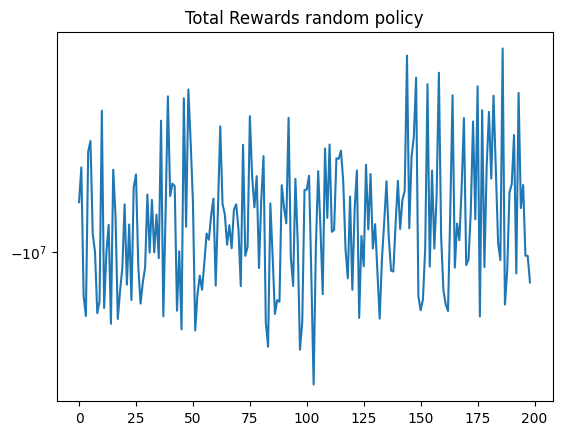

In [12]:
import matplotlib.pyplot as plt
plt.title(f'Total Rewards random policy')
plt.yscale('symlog')
plt.plot(totalRewards)
plt.savefig("Total Rewards random policy",dpi=200)

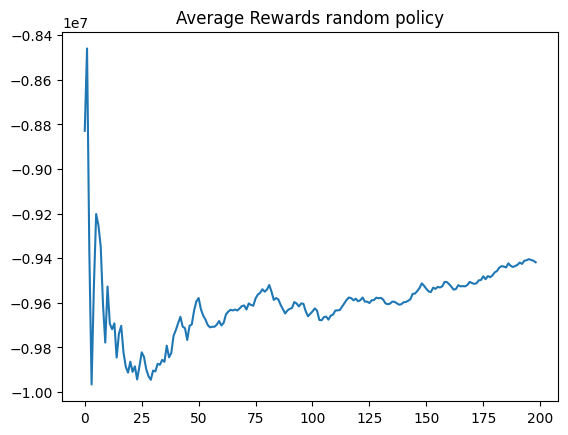

In [13]:
plt.clf()
plt.title(f'Average Rewards random policy')
# plt.yscale('symlog')
plt.plot(averageRewards)
plt.savefig("Average Rewards random policy",dpi=200)